# Lab 6
Noam Yan

## Setup

In [73]:
import pickle
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [92]:
# 1m fake data, poisson distribution with mean = 100.
num = int(1e6)
bg = stats.poisson.rvs(100,size=num)

## Problem 1

In [7]:
threshold = stats.poisson.isf(q=stats.norm.sf(5),mu=100,loc=0)

##  Problem 2
I have to choose 8 sigma because other values would result in nan for signal.

In [93]:
signal = stats.poisson.isf(q=stats.norm.sf(8),mu=100,loc=0)
signal = np.repeat([signal],bg.shape[0])

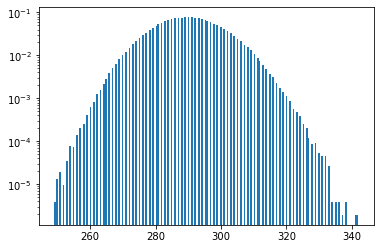

In [94]:
plt.hist(bg+signal,180,density=True)
plt.yscale('log')
plt.show()

In [156]:
p,b = np.histogram(bg+signal,180,density=True)
b[np.where(p==p.max())]

array([289.81666667])

In [160]:
b[80]

290.3333333333333

# Problem 3


In [175]:
# We are not able to calculate the 30-sigma value, so I simply use 300 insted.
sigRange = stats.uniform.rvs(loc=0, scale=300, size=num)

data = bg + sigRange

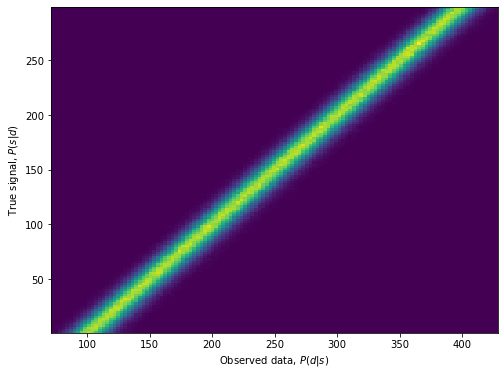

In [176]:
bins = 150
signaledges = np.linspace(0,300,bins)
dataedges = np.linspace(70,430,int(bins*300/(430-70)))

Psd, xrange, yrange= np.histogram2d(data,sigRange, bins=[dataedges,signaledges], density=True)

datacenters = (dataedges[:-1] + dataedges[1:]) / 2
signalcenters = (signaledges[:-1] + signaledges[1:]) / 2
plt.pcolormesh(datacenters,signalcenters,Psd.T)
plt.ylabel('True signal, $P(s|d)$')
plt.xlabel('Observed data, $P(d|s)$')
plt.show()

a) I am simulating observations of data injected with different value of signals who ranges from 0 to 300.<br>
b) Let's extract the slice where signal=190.

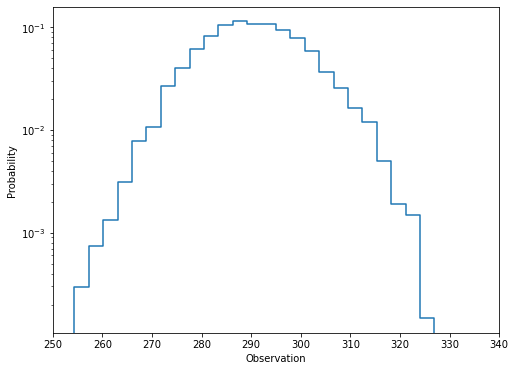

In [177]:
index = np.digitize(190,yrange)
likelyhood = Psd[:,index]
likelyhood = np.squeeze(likelyhood)
# Renormalize
ratio = 1 / np.sum(likelyhood)
likelyhood = likelyhood*ratio

plt.step(datacenters,likelyhood)
plt.ylabel('Probability')
plt.xlabel('Observation')
plt.xlim([250,340])
plt.yscale('log')
plt.show()

c)

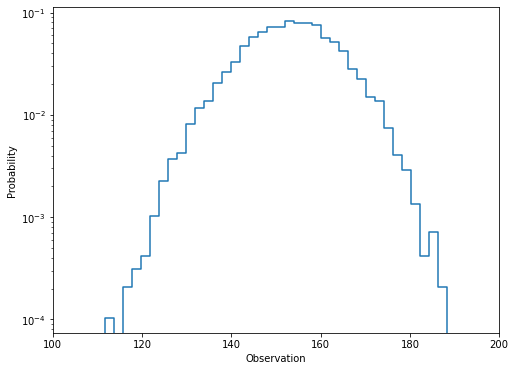

In [178]:
index = np.digitize(250,xrange)
posterior = Psd[index,:]
# Renormalize
ratio = 1 / np.sum(posterior)
posterior = posterior * ratio

plt.step(signalcenters,posterior)
plt.ylabel('Probability')
plt.xlabel('Observation')
plt.xlim([100,200])
plt.yscale('log')
plt.show()

d) the mean value should be (signal - mean of background) = 250 - 100 = 150.

In [179]:
center = np.digitize(150,signalcenters)

total = 0
pointer = center
while total < .341:
    pointer += 1
    total += posterior[pointer]
pos_1sig = signalcenters[pointer]

total = 0
pointer = center
while total < .341:
    pointer -= 1
    total += posterior[pointer]
neg_1sig = signalcenters[pointer]

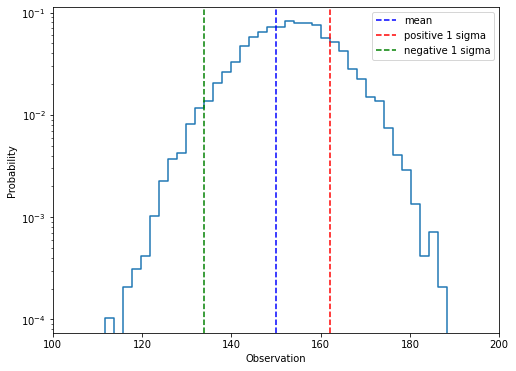

In [180]:
plt.rcParams["figure.figsize"] = (8,6)
plt.step(signalcenters,posterior)
plt.axvline(150,color='b', linestyle='--',label='mean')
plt.axvline(pos_1sig, color='r', linestyle='--',label='positive 1 sigma')
plt.axvline(neg_1sig, color='g', linestyle='--',label='negative 1 sigma')

plt.ylabel('Probability')
plt.xlabel('Observation')
plt.xlim([100,200])
plt.legend()
plt.yscale('log')
plt.show()

In [181]:
signalcenters[np.where(posterior==posterior.max())]

array([154.02684564])